In [5]:
import numpy as np
import pandas as pd
from datetime import datetime


msft = pd.read_csv('monthly_MSFT_2.csv')
ibm = pd.read_csv('monthly_IBM.csv')

# test2msft = read_csv('monthly_MSFT_2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
prueba = msft[['timestamp', 'close']].head(32)
prueba.set_index('timestamp', inplace=True)

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
test = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [6]:
test.head()




Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

In [7]:
msft.head()

,timestamp,open,high,low,close,volume
0,2020-11-27,204.29,228.12,200.12,215.23,540260437
1,2020-10-30,213.49,225.21,199.62,202.47,631674298
2,2020-09-30,225.51,232.86,196.25,210.33,768528897
3,2020-08-31,211.52,231.15,203.14,225.53,692382980
4,2020-07-31,203.14,216.38,197.51,205.01,769842002


In [8]:
ibm.head()

,timestamp,open,high,low,close,volume
0,2020-11-27,112.65,125.313,111.16,124.35,97473109
1,2020-10-30,122.36,135.500,105.92,111.66,159130911
2,2020-09-30,122.85,129.950,116.48,121.67,84510174
3,2020-08-31,123.50,130.470,122.15,123.31,74033007
4,2020-07-31,120.27,132.170,115.20,122.94,113972765


In [9]:
msft2 = msft[['timestamp', 'close']].head(32)
ibm2 = ibm[['timestamp', 'close']].head(32)

In [10]:
msft2.set_index('timestamp', inplace=True)
ibm2.set_index('timestamp', inplace=True)

In [35]:
print(test[1])

145.9


In [11]:
ibm2.head()

,close
timestamp,
2020-11-27,124.35
2020-10-30,111.66
2020-09-30,121.67
2020-08-31,123.31
2020-07-31,122.94


Month=1, Predicted=140.214435, Expected=117.940000
Month=2, Predicted=104.575378, Expected=112.030000
Month=3, Predicted=106.476167, Expected=104.430000
Month=4, Predicted=95.458937, Expected=101.570000
Month=5, Predicted=91.094826, Expected=110.890000
Month=6, Predicted=133.131107, Expected=106.810000
Month=7, Predicted=109.691669, Expected=114.370000
Month=8, Predicted=107.432429, Expected=112.330000
Month=9, Predicted=98.985434, Expected=106.080000
Month=10, Predicted=99.655052, Expected=98.610000
Month=11, Predicted=86.778781, Expected=98.840000
Month=12, Predicted=124.150060, Expected=93.520000
Test RMSE: 15.435


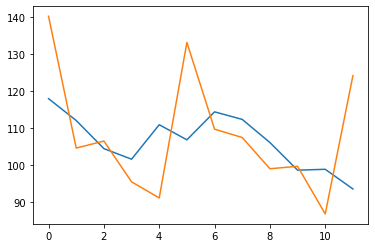

In [12]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
"""
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
"""
import tensorflow as tf
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = float(dataset[i]) - float(dataset[i - interval])
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset, this contain data of microsoft and ibm
# series = df2
series = msft2
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

Month=11, Predicted=135.450066, Expected=93.520000
Month=11, Predicted=89.113966, Expected=93.520000
Month=11, Predicted=104.606243, Expected=93.520000
Month=11, Predicted=91.578513, Expected=93.520000
Month=11, Predicted=83.011862, Expected=93.520000
Month=11, Predicted=151.647955, Expected=93.520000
Month=11, Predicted=129.766995, Expected=93.520000
Month=11, Predicted=92.894596, Expected=93.520000
Month=11, Predicted=94.097141, Expected=93.520000
Month=11, Predicted=95.036742, Expected=93.520000
Month=11, Predicted=81.853800, Expected=93.520000
[array([104.57537766]), array([106.47616728]), array([95.45893694]), array([91.09482561]), array([133.13110743]), array([109.69166917]), array([107.43242917]), array([98.98543366]), array([99.6550517]), array([86.77878113]), array([124.1500603])]
[135.45006648258527, 89.11396577375903, 104.6062428946364, 91.57851259683218, 83.01186238924865, 151.64795538902618, 129.76699518708077, 92.89459629303859, 94.09714111126769, 95.0367421331413, 81.853

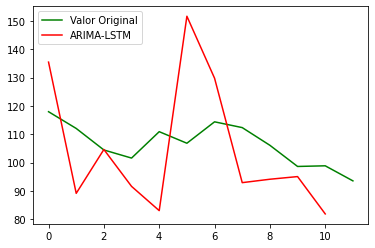

In [20]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
#from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
 


X = predictions # from LSTM
size = int(len(X) * 0.62)

train, test = X[0:size], X[1:len(X)]

history = [x for x in train]
predictions2 = list()
for t in range(len(test)):
	model = sm.tsa.arima.ARIMA(history, order=(1,2,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions2.append(yhat)
	obs = test[t]
	history.append(obs)
	print('Month=%d, Predicted=%f, Expected=%f' % (i, yhat, expected))
print(test)
print(predictions2)


# plot
pyplot.plot(raw_values[-12:], color='green')
pyplot.plot(predictions2, color='red')
pyplot.legend(['Valor Original','ARIMA-LSTM'], loc='upper left')